In [1]:
#!pip install numpy
#!pip install pandas
#!pip install scipy
#!pip install math
#!pip install pickle
#!pip install statistics
#!pip install matplotlib
#!pip install seaborn
#!pip install time
#!pip install scikit-learn
#!pip install xgboost
import numpy as np
import pandas as pd
from scipy.stats import binom
import math
import pickle
from statistics import mean, stdev
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from algo import *
from foldrm import *
from utils import *
from datasets import *



In [2]:
datasets = [wine, ecoli, weight_lifting, wall_robot, page_blocks, nursery, dry_bean]
dataset_names = ["Wine", "Ecoli", "Weight Lifting", "Wall Robot", "Page Blocks", "Nursery", "Dry Bean"]

from sklearn.preprocessing import LabelEncoder
import pandas as pd

def run_xgboost(data):
    results = []
    start_time = time.time()

    label_encoder = LabelEncoder()
    _, all_labels = split_xy(data)
    label_encoder.fit(np.unique(all_labels))  # Fit the encoder to all unique labels

    for _ in range(30):
        data_train, data_test = split_data(data, ratio=0.8)
        X_train, Y_train = split_xy(data_train)
        X_test, Y_test = split_xy(data_test)

        # Encode labels
        Y_train = label_encoder.transform(Y_train)
        Y_test = label_encoder.transform(Y_test)

        # Convert X_train and X_test to DataFrames if not already
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

        # Handle categorical data using one-hot encoding
        X_train = pd.get_dummies(X_train, drop_first=True)
        X_test = pd.get_dummies(X_test, drop_first=True)

        # Ensure both DataFrames have the same structure
        X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

        model = XGBClassifier()
        try:
            model.fit(X_train, Y_train)
            predictions = model.predict(X_test)
            accuracy = accuracy_score(Y_test, predictions)
            results.append(accuracy)
        except ValueError as e:
            print(f"Error fitting model: {e}")
            continue
    
    elapsed_time = time.time() - start_time
    avg_time = elapsed_time / 30
    avg_accuracy = np.mean(results) if results else 0
    std_accuracy = np.std(results) if results else 0
    return avg_accuracy, std_accuracy, avg_time

#Optimization thresholds for each dataset
optimization_params = {
    "Wine": {"X": 0.55, "Y": 0.02}, #done
    "Ecoli": {"X": 0.60, "Y": 0.08}, #done
    "Weight Lifting": {"X": 0.9, "Y": 0.02}, #done
    "Wall Robot": {"X": 0.65, "Y": 0.01}, #done
    "Page Blocks": {"X": 0.7, "Y": 0.09}, #done
    "Nursery": {"X": 0.55, "Y": 0.04}, #done
    "Dry Bean": {"X": 0.65, "Y": 0.01} #done
}

# Initialize DataFrame
results_df = pd.DataFrame(columns=["Dataset", "Model", "Avg Accuracy", "Std Accuracy", "Avg Time", "Num Rules Avg", "Num Rules Std"])
results_list = []

# Loop over datasets
for dataset, name in zip(datasets, dataset_names):
    print(f"Starting {dataset}")
    model, data = dataset()
    # XGBoost results
    print("Starting XGBoost")
    xgb_acc, xgb_std, xgb_time = run_xgboost(data)
    # FOLD-RM results
    print("Starting FOLD-RM")
    start_time = time.time()
    fr_avg_acc, fr_std_acc, fr_avg_rules, fr_std_rules = run_trials(data, model, num_trials=30)
    fr_time = (time.time() - start_time) / 30
    print("Starting CON-FOLD Default")
    # CON-FOLD Default results
    start_time = time.time()
    cf_avg_acc, cf_std_acc, cf_avg_rules, cf_std_rules = run_improved_pruned_trials(data, model, num_trials=30)
    cf_time = (time.time() - start_time) / 30
    print("Starting CON-FOLD Optimised")
    # CON-FOLD Optimised results
    params = optimization_params[name]
    start_time = time.time()
    cfo_avg_acc, cfo_std_acc, cfo_avg_rules, cfo_std_rules = run_improved_pruned_trials(data, model, num_trials=30, confidence_threshold=params["X"], improvement_threshold=params["Y"])
    cfo_time = (time.time() - start_time) / 30
    # FOLD-SE placeholder results, will need to fill in manually
    se_time, se_acc, se_rules = 0.01, 0.5, 7
    
    # Collecting results in DataFrame
    results_list.append([
        name,
        xgb_acc, xgb_std, xgb_time, #np.nan, np.nan,
        fr_avg_acc, fr_std_acc, fr_time, fr_avg_rules, fr_std_rules,
        cf_avg_acc, cf_std_acc, cf_time, cf_avg_rules, cf_std_rules,
        cfo_avg_acc, cfo_std_acc, cfo_time, cfo_avg_rules, cfo_std_rules,
        se_acc, np.nan, se_time, se_rules, np.nan
    ])

# Define the columns with MultiIndex for better organization
columns = pd.MultiIndex.from_tuples([
    ('Dataset', ''),
    ('XGBoost', 'Avg Accuracy'), ('XGBoost', 'Std Accuracy'), ('XGBoost', 'Avg Time'), #('XGBoost', 'Num Rules Avg'), ('XGBoost', 'Num Rules Std'),
    ('FOLD-RM', 'Avg Accuracy'), ('FOLD-RM', 'Std Accuracy'), ('FOLD-RM', 'Avg Time'), ('FOLD-RM', 'Num Rules Avg'), ('FOLD-RM', 'Num Rules Std'),
    ('CON-FOLD Default', 'Avg Accuracy'), ('CON-FOLD Default', 'Std Accuracy'), ('CON-FOLD Default', 'Avg Time'), ('CON-FOLD Default', 'Num Rules Avg'), ('CON-FOLD Default', 'Num Rules Std'),
    ('CON-FOLD Optimised', 'Avg Accuracy'), ('CON-FOLD Optimised', 'Std Accuracy'), ('CON-FOLD Optimised', 'Avg Time'), ('CON-FOLD Optimised', 'Num Rules Avg'), ('CON-FOLD Optimised', 'Num Rules Std'),
    ('FOLD-SE', 'Avg Accuracy'), ('FOLD-SE', 'Std Accuracy'), ('FOLD-SE', 'Avg Time'), ('FOLD-SE', 'Num Rules Avg'), ('FOLD-SE', 'Num Rules Std')
], names=['Model', 'Statistic'])

# Create the DataFrame
results_df = pd.DataFrame(results_list, columns=columns)

# Print to see the DataFrame structure
print(results_df.head(7))

Starting <function wine at 0x0000021B539B6560>

% wine dataset (178, 14)
Starting XGBoost
Starting FOLD-RM
Starting CON-FOLD Default
Starting CON-FOLD Optimised
Starting <function ecoli at 0x0000021B539B6440>

% ecoli dataset (336, 9)
Starting XGBoost
Error fitting model: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [0 1 2 4 5 6 7]
Error fitting model: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got [0 1 3 4 5 6 7]
Starting FOLD-RM
Starting CON-FOLD Default
Starting CON-FOLD Optimised
Starting <function weight_lifting at 0x0000021B539B6950>

% weight lifting dataset (4024, 155)
Starting XGBoost
Starting FOLD-RM
Starting CON-FOLD Default
Starting CON-FOLD Optimised
Starting <function wall_robot at 0x0000021B539B6EF0>

% wall_following_robot dataset (5456, 25)
Starting XGBoost
Starting FOLD-RM
Starting CON-FOLD Default
Starting CON-FOLD Optimised
Starting <function page_blocks at 0x0000021B539B6D40>

% page blocks


% ecoli dataset (336, 9)
Average Score: 0.7919607843137255, Score Standard Deviation: 0.04590568607544006
Average Number of Rules: 38.59, Number of Rules Standard Deviation: 5.398677529131107
started (0.55,0.01)


C:\Users\Lachlan McGinness\AppData\Local\Temp\ipykernel_12976\4056204839.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


started (0.55,0.02)
started (0.55,0.03)
started (0.55,0.04)
started (0.55,0.05)
started (0.55,0.06)
started (0.55,0.07)
started (0.55,0.08)
started (0.55,0.09)
started (0.6,0.01)
started (0.6,0.02)
started (0.6,0.03)
started (0.6,0.04)
started (0.6,0.05)
started (0.6,0.06)
started (0.6,0.07)
started (0.6,0.08)
started (0.6,0.09)
started (0.65,0.01)
started (0.65,0.02)
started (0.65,0.03)
started (0.65,0.04)
started (0.65,0.05)
started (0.65,0.06)
started (0.65,0.07)
started (0.65,0.08)
started (0.65,0.09)
started (0.7,0.01)
started (0.7,0.02)
started (0.7,0.03)
started (0.7,0.04)
started (0.7,0.05)
started (0.7,0.06)
started (0.7,0.07)
started (0.7,0.08)
started (0.7,0.09)
started (0.75,0.01)
started (0.75,0.02)
started (0.75,0.03)
started (0.75,0.04)
started (0.75,0.05)
started (0.75,0.06)
started (0.75,0.07)
started (0.75,0.08)
started (0.75,0.09)
started (0.8,0.01)
started (0.8,0.02)
started (0.8,0.03)
started (0.8,0.04)
started (0.8,0.05)
started (0.8,0.06)
started (0.8,0.07)
start

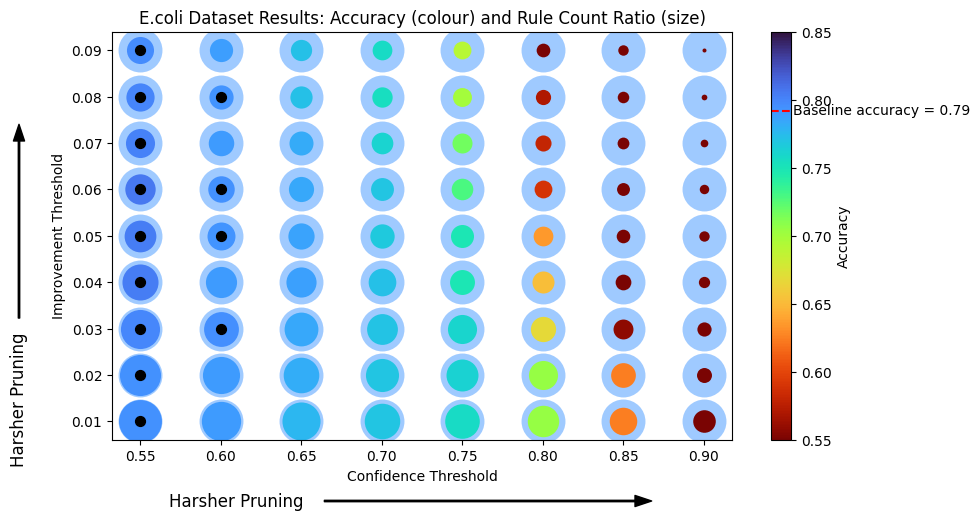

In [3]:
# Setting the baseline
model, data = ecoli()
benchmark_average_score, benchmark_score_stdev, benchmark_average_rule_count, benchmark_rule_count_stdev = run_trials(data, model, num_trials=300)
print(f"Average Score: {benchmark_average_score}, Score Standard Deviation: {benchmark_score_stdev}")
print(f"Average Number of Rules: {benchmark_average_rule_count}, Number of Rules Standard Deviation: {benchmark_rule_count_stdev}")
confidence_thresholds = [0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
improvement_thresholds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

# Prepare DataFrame to store results
results = pd.DataFrame(columns=['Confidence Threshold', 'Improvement Threshold', 'Average Score', 'Rule Count Ratio'])

# Run the experiment loops
for conf_threshold in confidence_thresholds:
    for impr_threshold in improvement_thresholds:
        print(f"started ({conf_threshold},{impr_threshold})")
        average_score, score_stdev, average_rule_count, rule_count_stdev = run_improved_pruned_trials(
            data, model, num_trials=300, confidence_threshold=conf_threshold, improvement_threshold=impr_threshold)
        rule_count_ratio = average_rule_count / benchmark_average_rule_count
        new_row = pd.DataFrame({
            'Confidence Threshold': [conf_threshold],
            'Improvement Threshold': [impr_threshold],
            'Average Score': [average_score],
            'Rule Count Ratio': [rule_count_ratio]
        })
        results = pd.concat([results, new_row], ignore_index=True)

# E.Coli
cmap = sns.color_palette("turbo_r", as_cmap=True)

vmin=0.55
vmax=0.85

# Plotting the baseline and experiment results
fig, ax = plt.subplots(figsize=(10, 6))

normalized_baseline = (benchmark_average_score - vmin) / (vmax - vmin)
baseline_position = (benchmark_average_score - vmin) / (vmax - vmin)
baseline_color = cmap(normalized_baseline)

# Calculate baseline circle size
baseline_circle_size = (1) * 1000

for _, row in results.iterrows():
    # Baseline gray circle
    ax.scatter(row['Confidence Threshold'], row['Improvement Threshold'], s=baseline_circle_size, linewidth=0, alpha=0.5, color=baseline_color)
    # Experiment circle
    experiment_circle_size = (row['Rule Count Ratio'] **1) * 1000 
    ax.scatter(row['Confidence Threshold'], row['Improvement Threshold'], s=experiment_circle_size, c=row['Average Score'], linewidth=0, cmap=cmap, vmin=vmin, vmax=vmax)
    if row['Average Score'] > benchmark_average_score:
        ax.scatter(row['Confidence Threshold'], row['Improvement Threshold'], s=50, color='black', zorder=3)
            
# Add legend for the baseline only once
handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(handles[:1], labels[:1], loc="best")

# Color bar for the accuracy
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Accuracy')
cbar.ax.axhline(y=benchmark_average_score, color='red', linestyle='--', label=f'Baseline accuracy = {benchmark_average_score:.2f}')
x_position = 1.1  # Right of the colorbar
y_position = baseline_position

# Add the baseline accuracy label at specific coordinates
cbar.ax.text(x_position, y_position, f'Baseline accuracy = {benchmark_average_score:.2f}',
             verticalalignment='center', horizontalalignment='left', transform=cbar.ax.transAxes)

# Set labels and title
ax.set_xlabel('Confidence Threshold')
ax.set_ylabel('Improvement Threshold')
ax.set_title('E.coli Dataset Results: Accuracy (colour) and Rule Count Ratio (size)')

ax.annotate('Harsher Pruning', xy=(-0.15, 0.8), xytext=(-0.15, 0.1),
             xycoords='axes fraction', textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=12, ha='center', va='center', rotation=90)

ax.annotate('Harsher Pruning', xy=(0.9, -0.15), xytext=(0.2, -0.15),
             xycoords='axes fraction', textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=12, ha='center', va='center')


# Show plot
fig.subplots_adjust(bottom=0.2)
plt.show()

#fig.savefig('Ecoli_results300trials.png', dpi=600)

In [ ]:
def get_inverse_brier_score(Ystar_tuples, Y_test):
    #Note Ystar_tuples should be a list of tuples of length 2. The first entry is the predicted class, the second entry is the confidence.
    #Note Ystar should be a list of strings (classes)
    
    #First check that the lengths of the two lists are the same:
    if len(Ystar_tuples) != len(Y_test):
        return 0
    
    num_examples = len(Y_test)
    Cumulative_Brier = float(0)
    for i in range(num_examples):
        if Ystar_tuples[i][0] == None:
            Cumulative_Brier += 0.25
        else:
            if Ystar_tuples[i][0] == Y_test[i]:
                Cumulative_Brier += (1-Ystar_tuples[i][1])**2
            else:
                Cumulative_Brier += (Ystar_tuples[i][1])**2
    Brier_score = Cumulative_Brier/num_examples
    Inverse_Brier_score = 1 - Brier_score
    return Inverse_Brier_score

from datasets import ecoli
model, data = ecoli()

results_list = []
training_ratios = np.arange(0.03, 0.21, 0.01)
label_encoder = LabelEncoder()
_, all_labels = split_xy(data)
label_encoder.fit(np.unique(all_labels))

for ratio in training_ratios:
    unpruned_scores = []
    unpruned_confidences = []
    pruned_scores = []
    pruned_confidences = []
    XGBresults = []
    for _ in range(30):
        data_train, data_test = split_data_stratified(data, ratio)
        X_train, Y_train = split_xy(data_train)
        X_test, Y_test = split_xy(data_test)
        #print(Y_test)
        #Run Pruned Trials
        pruned_model, _ = ecoli()
        num_rules = float(0)
        total_confidence = float(0)
        pruned_model.confidence_fit(data_train, improvement_threshold = 0.02)  # Train model on training set
        pruned_model.rules = prune_rules(pruned_model.rules, confidence=0.6)
        pruned_model.asp()
        for item in pruned_model.crs:
            #print(item)
            if item[-1] >0:
                num_rules += 1
                total_confidence += item[-1]
        average_confidence = total_confidence/num_rules
        pruned_confidences.append(average_confidence)
        
        Ystar_test_tuples = pruned_model.predict(X_test)  # Predict on test set
        Ystar_test = [y[0] for y in Ystar_test_tuples]  # Extract predicted labels
        score = get_inverse_brier_score(Ystar_test_tuples, Y_test)  # Calculate score for this trial
        pruned_scores.append(score)
        
        #Run unpruned Trials
        unpruned_model, _ = ecoli()
        num_rules = float(0)
        total_confidence = float(0)
        unpruned_model.fit(data_train)  # Train model on training set
        unpruned_model.asp()
        for item in unpruned_model.crs:
            #print(item)
            if item[-1] >0:
                num_rules += 1
                total_confidence += item[-1]
        average_confidence = total_confidence/num_rules
        unpruned_confidences.append(average_confidence)
        #print(f"Average unpruned confidence: {average_confidence}")
        
        Ystar_test_tuples = unpruned_model.predict(X_test)  # Predict on test set
        Ystar_test = [y[0] for y in Ystar_test_tuples]  # Extract predicted labels
        score = get_inverse_brier_score(Ystar_test_tuples, Y_test)  # Calculate score for this trial
        unpruned_scores.append(score)
        
        #Run XGBoost
        Y_train = label_encoder.transform(Y_train)
        Y_test = label_encoder.transform(Y_test)
        
        # Convert X_train and X_test to DataFrames if not already
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)
        
        # Handle categorical data using one-hot encoding
        X_train = pd.get_dummies(X_train, drop_first=True)
        X_test = pd.get_dummies(X_test, drop_first=True)

        # Ensure both DataFrames have the same structure
        X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)
        
        XGBmodel = XGBClassifier()
        XGBmodel.fit(X_train, Y_train)
        predictions = XGBmodel.predict(X_test)
        XGBaccuracy = accuracy_score(Y_test, predictions)
        XGBresults.append(XGBaccuracy)
            
    average_pruned_score = mean(pruned_scores)
    pruned_score_stdev = stdev(pruned_scores) if len(pruned_scores) >= 1 else 0
    average_pruned_confidence = mean(pruned_confidences)
    
    average_unpruned_score = mean(unpruned_scores)
    unpruned_score_stdev = stdev(unpruned_scores) if len(unpruned_scores) >= 1 else 0
    average_unpruned_confidence = mean(unpruned_confidences)

    xgb_acc = np.mean(XGBresults) if XGBresults else 0
    xgb_std = np.std(XGBresults) if XGBresults else 0
    
    results_list.append([f"{int(ratio * 100)}%", xgb_acc, xgb_std, 
                         average_unpruned_score, unpruned_score_stdev,
                         average_pruned_score, pruned_score_stdev])

results_df = pd.DataFrame(results_list, columns=['Train Ratio', 'XGBoost Accuracy', 'XGBoost STD',
                                                 'Unpruned Acc', 'Unpruned STD',
                                                 'Pruned Acc', 'Pruned STD'])

data = results_list

# Unpacking the data
x_values = [sublist[0] for sublist in data]
xgboost_y_values = [sublist[1] for sublist in data]
xgboost_y_errors = [sublist[2] for sublist in data]
unpruned_confold_y_values = [sublist[3] for sublist in data]
unpruned_confold_y_errors = [sublist[4] for sublist in data]
pruned_confold_y_values = [sublist[5] for sublist in data]
pruned_confold_y_errors = [sublist[6] for sublist in data]

fig, ax1 = plt.subplots()

ax1.errorbar(x_values, xgboost_y_values, yerr=xgboost_y_errors, fmt='o-', color='b', 
             label='XGBoost', capsize=5)
ax1.errorbar(x_values, unpruned_confold_y_values, yerr=unpruned_confold_y_errors, fmt='o-', color='g', 
             label='Unpruned CON-FOLD' , capsize=5)
ax1.errorbar(x_values, pruned_confold_y_values, yerr=pruned_confold_y_errors, fmt='o-', color='r', 
             label='Pruned CON-FOLD' , capsize=5)
ax1.set_xlabel('Percentage Training Data (%)')
ax1.set_ylabel('Inverse Brier Score')
ax1.set_ylim(0.5, 0.85)
ax1.legend(loc='lower right')

plt.xticks(x_values[::2])
plt.title(f'''Comparison of Inverse Brier Score for E. coli
 dataset for small amounts of training data.''')
plt.show()

#fig.savefig('LowBrierScoreRatioFixed.png', dpi=600)


% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dataset (336, 9)

% ecoli dat